In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import random
import math
from scipy.linalg import eig

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# Random config
def f_rand_config(s,m):
    rand = np.random.uniform(s, size=2*m)
    coords = np.reshape(rand,(m,2)).T
    return coords

In [3]:
# Fly toward center of mass
def f_rule1(X,m):
    CoM = np.sum(X,axis=1)/m
    return np.reshape(CoM,[2,1]) - X

In [4]:
# Fly toward center of mass of boids in neighborhood
def f_rule1_v2(X,Xp,m,beta,threshold):
    Xp_2 = np.zeros((2,m))
    Xp_2 += Xp
    for j in np.arange(m):
        for i in np.arange(m):
            if i > j and 0 < np.sqrt((X[0][j]-X[0][i])**2+(X[1][j]-X[1][i])**2) < 5*threshold:
                Xp_2[:,j] += (1-beta)*(X[:,i] - X[:,j])/m
    return Xp_2

In [5]:
# Fly away from nearby boids
def f_rule2(X,m,threshold):
    F = np.zeros((2,m))

    for j in np.arange(m):
        for i in np.arange(m):
            if i > j and 0 < np.sqrt((X[0][j]-X[0][i])**2+(X[1][j]-X[1][i])**2) < threshold:
                F[0,j] = np.sign(X[0][j]-X[0][i])*np.exp(-np.abs(X[0][j]-X[0][i]))
                F[1,j] = np.sign(X[1][j]-X[1][i])*np.exp(-np.abs(X[1][j]-X[1][i]))
                F[0,i] = -F[0,j]
                F[1,i] = -F[1,j]

    return F

In [6]:
# Move velocity toward that of average
def f_rule3(Xp,m,beta):
    CoV = np.sum(Xp,axis=1)/m
    return beta*Xp + (1-beta)*np.reshape(CoV,[2,1])

In [7]:
# Move velocity toward that of average of nearby boids
def f_rule3_v2(X,Xp,m,beta,threshold):
    Xp_2 = np.zeros((2,m))
    Xp_2 += beta*Xp
    for j in np.arange(m):
        for i in np.arange(m):
            if i > j and 0 < np.sqrt((X[0][j]-X[0][i])**2+(X[1][j]-X[1][i])**2) < threshold:
                Xp_2[:,j] += (1-beta)*Xp[:,i]/m

    return Xp_2

In [8]:
# Stay on screen
def f_rule4(X,m):
    F = np.zeros((2,m))

    for i in np.arange(m):
        if X[0][i] > s:
            F[0,i] = -1
        if X[0][i] < 0:
            F[0,i] = 1
        if X[1][i] > s:
            F[1,i] = -1
        if X[1][i] < 0:
            F[1,i] = 1
    return F

In [9]:
# Limit speed
def f_rule5(Xp,m,speed_thresh):
    for i in np.arange(m):
        if Xp[0][i] > speed_thresh:
            Xp[0][i] = speed_thresh
        if Xp[1][i] > speed_thresh:
            Xp[1][i] = speed_thresh
    return Xp

In [22]:
# Solve the system's equations of motion
def f_DynamicSim(X0,tf,m,Xp0,dt,t0,threshold,beta,speed_thresh):

  Nt = int(tf/dt) + 1 # Number of time steps
  Xi = X0 # Initialize state at ith time step
  Xp = Xp0
  XN = np.zeros((2,m,Nt)) # Initialize nominal state
  XN[:,:,0] = X0 # Initial conditions
    
  i = 0 # Initialize iteration counter
  ti = t0 # Initialize time counter
  # Iterate over time interval:
  # (At final time step: i+1 = tf/dt, where i = ti/dt => ti = tf - dt)
  while ti <= tf-dt:
    
    # Update derivative using the equations of motion
#     Xp += rule1 + rule2 + rule3
    Xp += f_rule1(Xi,m) + 2*f_rule2(Xi,m,threshold) + 2*f_rule4(Xi,m)
#     Xp = f_rule1_v2(Xi,Xp,m,beta,threshold)
    Xp = f_rule3(Xp,m,beta)
#     Xp = f_rule3_v2(Xi,Xp,m,beta,threshold)
    Xp = f_rule5(Xp,m,speed_thresh)
    Xi = Xi + Xp*dt # Update state at ith time step
    XN[:,:,i+1] = Xi # Update nominal state
    i += 1 # Increment counter
    ti += dt # Increment timer

  # Ouput: Nominal state
  return XN

In [11]:
# Convert x-y coordinates to pixels in a matrix
def f_coords2mat(coords,s,dim):
    M = np.ones((dim,dim))
    idx = np.round(coords*(dim/s))
    for i in np.arange(m):
        mx = int(idx[0][i])
        my = int(idx[1][i])
        if mx >= 0 and mx < dim and my >= 0 and my < dim:
            M[mx,my] = 0
    return M

In [12]:
# Do the thing
def f_Compute_Boids(s,m,tf,dt,dim,threshold,beta,speed_thresh):
    Nt = int(tf/dt) + 1 # Number of time steps
    X0 = f_rand_config(s,m)
    XN = f_DynamicSim(X0,tf,m=m,dt=dt,Xp0=0,t0=0,threshold=threshold,beta=beta,speed_thresh=speed_thresh)

    M_v = np.zeros((dim,dim,Nt))
    for i in np.arange(Nt):
        M_v[:,:,i] = f_coords2mat(XN[:,:,i],s,dim)
    
    return M_v

In [13]:
# Enable interactive plot
%matplotlib notebook
import matplotlib.animation as animation

def init():
    im.set_data(np.zeros((dim,dim)))

def animate(i):
    im.set_data(M_v[:,:,i])
    return im, M

<IPython.core.display.Javascript object>


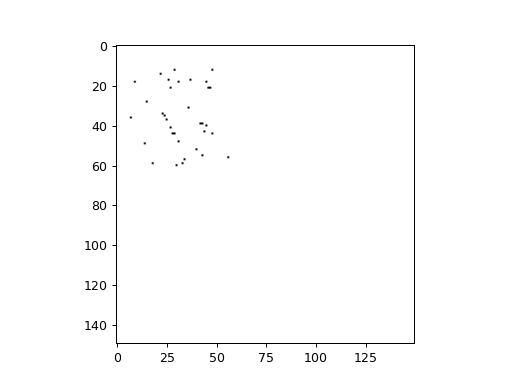

In [23]:
s = 10 # Size of the board
m = 40 # Number of boids
tf = 100 # Final time
dim=s*15 # Number of pixels along each dimension
dt = 0.1 # Timestep
Nt = int(tf/dt) + 1 # Number of time steps
threshold = s/10 # Boids look at other boids closer than the threshold
beta = 0.8 # Parameter determining how much to weigh current velocity vs average velocity
speed_thresh = 0.7*s # Limit on boid speed

M_v = f_Compute_Boids(s,m,tf,dt,dim,threshold,beta,speed_thresh)
fig, ax = plt.subplots()
im = plt.imshow(M_v[:,:,0], cmap='gist_gray', vmin=0, vmax=1)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt,interval=100)
plt.show()